# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные лежат в папке `/datasets/image_search/`.

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке: 

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке. 
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [ ]:
#!pip3 install sentence_transformers

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor, Pool, cv
from sklearn.metrics import make_scorer


from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import cross_val_score


from skorch import NeuralNetRegressor
from torchvision import transforms
import torchvision.models as models
import torch
import transformers
from torch import optim
import torch.nn.functional as F
import torch.nn as nn
import skorch
from tqdm import notebook

from sentence_transformers import SentenceTransformer, util
from PIL import Image


from PIL import Image
import os
import glob
import random
import re
import spacy
spacy.cli.download("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


Импортируем нужные библиотеки

In [ ]:
patch_dir = 'D:\\Data sets для проектов\\Сборный Проект - 4\\to_upload\\'

In [ ]:
col_names_train=['image',
                 'query_id', 
                 'query_text_train'] 

train_df = pd.read_csv(patch_dir + 'train_dataset.csv',
                       names=col_names_train,
                       header=0)

train_df.head(3)

,image,query_id,query_text_train
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


Сохраняем данные в переменную

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image             5822 non-null   object
 1   query_id          5822 non-null   object
 2   query_text_train  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


В df 3 столбца и 5822 строки, типы данных object

In [ ]:
col_names_test=['query_id', 
                'query_text_test', 
                'image'] 

test_df_queries = pd.read_csv(patch_dir + 'test_queries.csv', 
                              sep='|', 
                              names=col_names_test,
                              header=0,
                              index_col=0)

test_df_queries.head(3)

,query_id,query_text_test,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg


In [ ]:
test_df_queries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   query_id         500 non-null    object
 1   query_text_test  500 non-null    object
 2   image            500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


В тестовом df 500 строк и 1 столбец типа object

In [ ]:
test_df_images = pd.read_csv(
    patch_dir + 'test_images.csv', sep='\t')

test_df_images.head(3)

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg


In [ ]:
test_df_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


В тестовом df с картинками 100 строк и 1 столбец типа object

In [ ]:
col_names_crowd=['name_image', 
                 'id_image', 
                 'prop_people_image', 
                 'num_people_yes', 
                 'num_people_no'] 


crowd_df_annot = pd.read_csv(patch_dir + 'CrowdAnnotations.tsv', 
                             sep='\t',
                             names=col_names_crowd,
                             header=0)

crowd_df_annot.head(3)

,name_image,id_image,prop_people_image,num_people_yes,num_people_no
0,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
1,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3


При импорте данных переименовали столбцы, т к они были не корректными 

In [ ]:
crowd_df_annot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47829 entries, 0 to 47828
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name_image         47829 non-null  object 
 1   id_image           47829 non-null  object 
 2   prop_people_image  47829 non-null  float64
 3   num_people_yes     47829 non-null  int64  
 4   num_people_no      47829 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


В df 47829 строк и 5 столбцов, по 2 столбца типа object и int64, и еще один типа float64. Значений NaN нет. 

In [ ]:
col_names_expert=['name_image', 
                  'id_image', 
                  'prop_people_image', 
                  'num_people_yes', 
                  'num_people_no'] 


expert_df_annot = pd.read_csv(patch_dir + 'ExpertAnnotations.tsv', 
                             sep='\t',
                             names=col_names_expert,
                             header=0)

expert_df_annot.head(7)

,name_image,id_image,prop_people_image,num_people_yes,num_people_no
0,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
1,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
3,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2
4,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,1,1,1
5,1056338697_4f7d7ce270.jpg,3545652636_0746537307.jpg#2,1,1,1
6,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,1,1,2


In [ ]:
expert_df_annot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5821 entries, 0 to 5820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name_image         5821 non-null   object
 1   id_image           5821 non-null   object
 2   prop_people_image  5821 non-null   int64 
 3   num_people_yes     5821 non-null   int64 
 4   num_people_no      5821 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


В df 5821 строка и 5 столбцов, 2 столбца типа object и 3 столбца типа int64 

C:\Users\seryo\AppData\Local\Temp\ipykernel_30108\891506100.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  pic_box.add_subplot(7, 1, i+1)


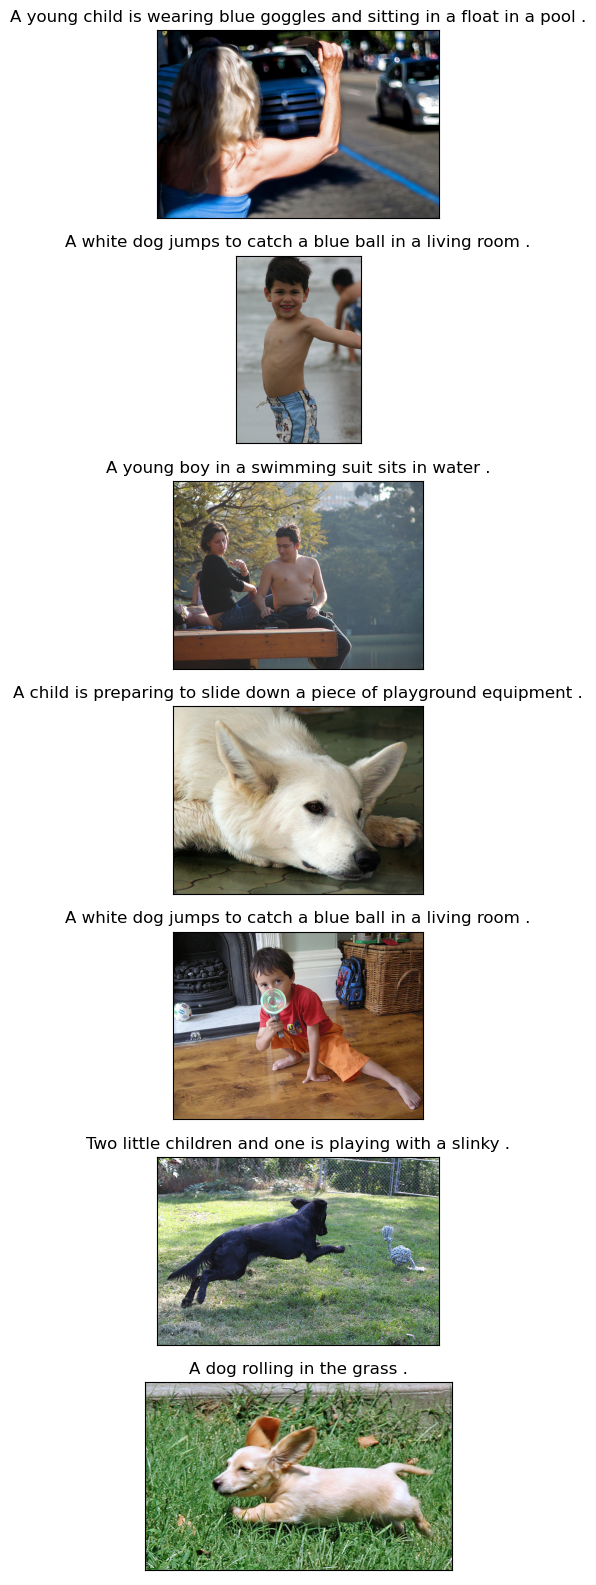

In [ ]:
i = 0
pictur_df = patch_dir + 'train_images\\'
pic_box = plt.figure(figsize=(20,20))
 
for i, image in enumerate(os.listdir(pictur_df)):
    if i < 7:
        pillow_image = Image.open(pictur_df+'\\'+image).convert('RGB')
        pic_box.add_subplot(7, 1, i+1)
        plt.yticks([])
        plt.xticks([])
        plt.title(train_df.query_text_train[train_df.image.tolist().index(image)])
        plt.imshow(pillow_image)
        i += 1

Из полученных изображений с подписями, не все изображения совпадают с подписью. Картинки совершенно разные

In [ ]:
expert_df_annot['mean_expert'] = round((expert_df_annot['prop_people_image'] 
                                        + expert_df_annot['num_people_yes'] 
                                        + expert_df_annot['num_people_no']) / 3).astype(int)
expert_df_annot.head(2)

,name_image,id_image,prop_people_image,num_people_yes,num_people_no,mean_expert
0,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1
1,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,1


Сделали новый столбец "mean_expert" с суммой оценок деленное на кол-во оценок с округлением по правилам математики. 

In [ ]:
def plt_chart(data, colum, titl, xlab, ylab):
    sns.displot(x=colum, aspect=2.5, data=data)
    plt.title(titl, fontsize=15,  y= 1)
    plt.xlabel(xlab, fontsize=14, labelpad=18)
    plt.ylabel(ylab, fontsize=14, labelpad=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)                               

Функция для построения графика

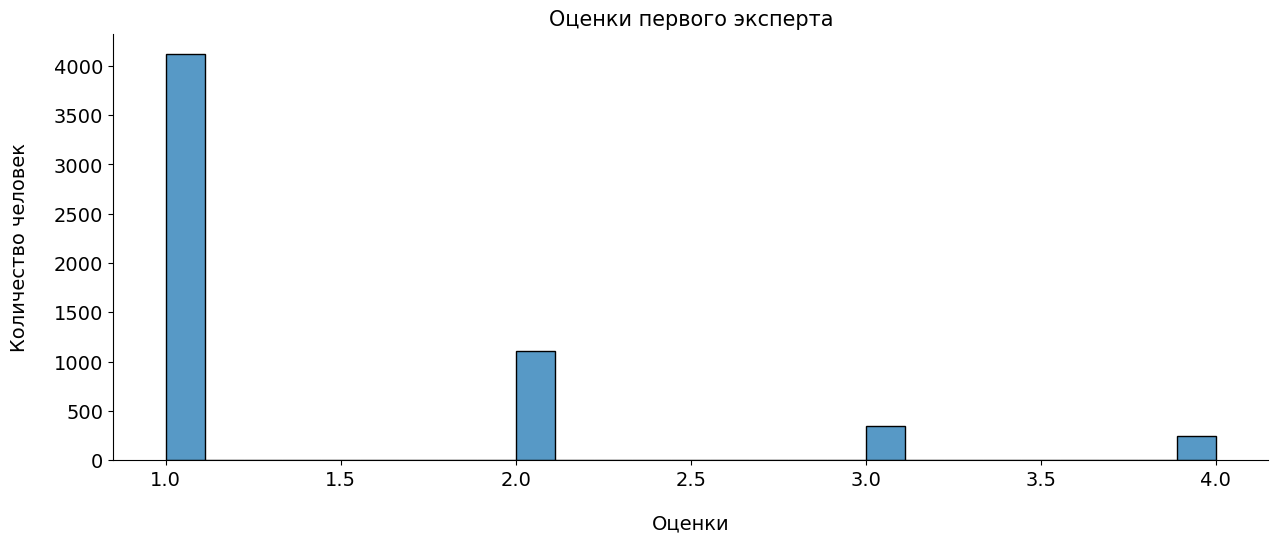

In [ ]:
plt_chart(expert_df_annot, 
          'prop_people_image', 
          'Оценки первого эксперта', 
          'Оценки', 
          'Количество человек')

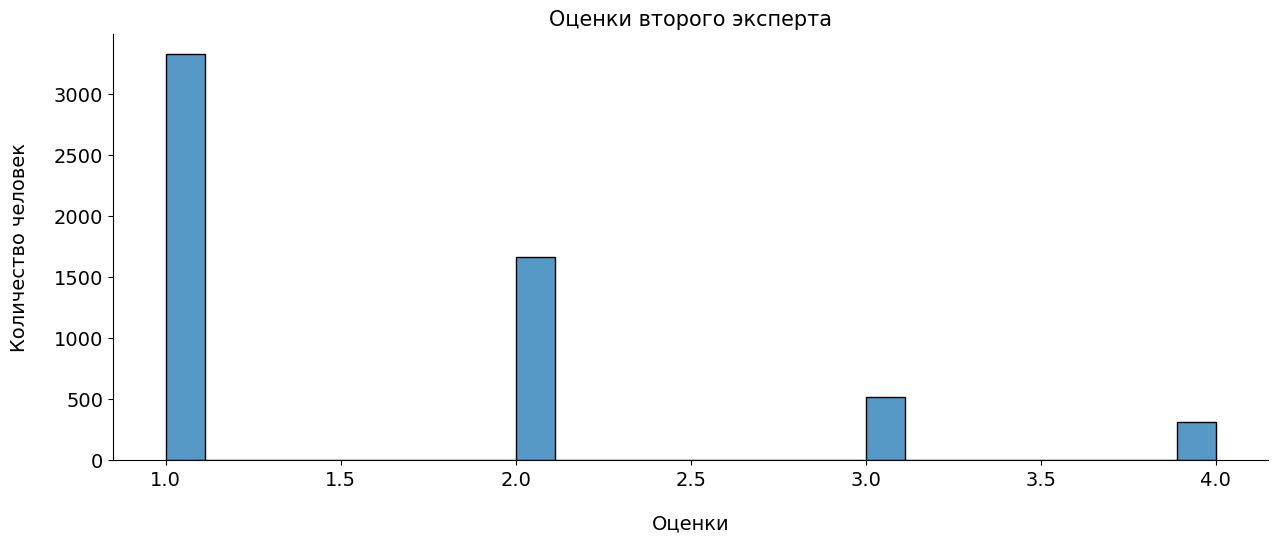

In [ ]:
plt_chart(expert_df_annot, 
          'num_people_yes', 
          'Оценки второго эксперта', 
          'Оценки', 
          'Количество человек')

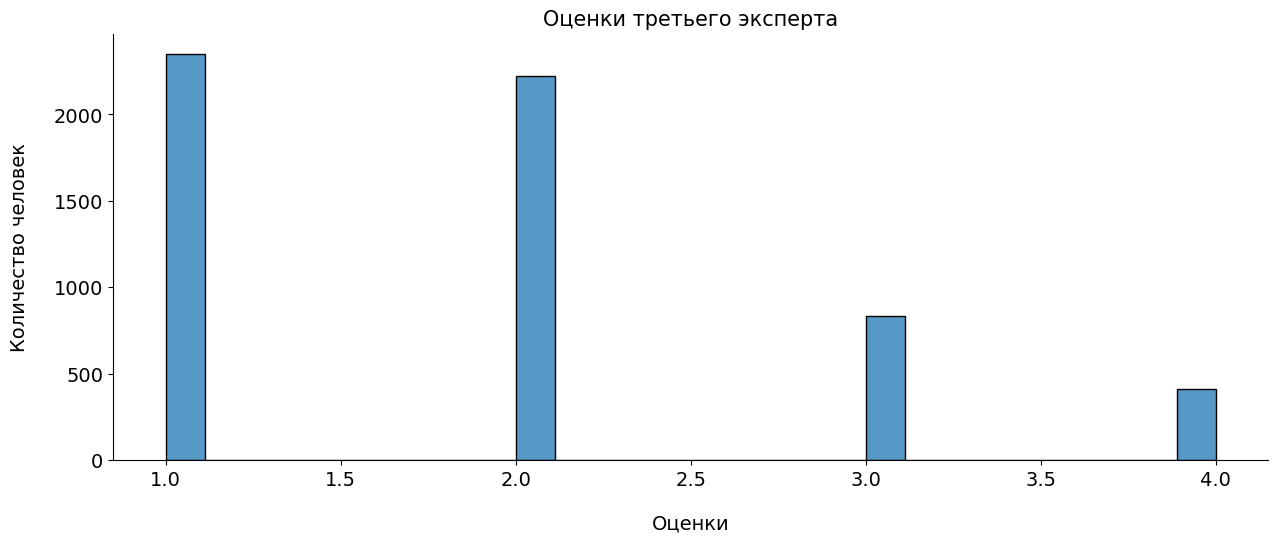

In [ ]:
plt_chart(expert_df_annot, 
          'num_people_no', 
          'Оценки третьего эксперта', 
          'Оценки', 
          'Количество человек')

По графикам, можно сделать вывод, что изображение и запрос совершенно не соответствуют друг другу, либо запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует.

In [ ]:
expert_df_annot[['prop_people_image', 
                 'num_people_yes', 
                 'num_people_no',
                 'mean_expert']] = expert_df_annot[['prop_people_image', 
                                                    'num_people_yes', 
                                                    'num_people_no',
                                                    'mean_expert']].apply(lambda x: minmax_scale(x))


expert_df_annot.head(3)

,name_image,id_image,prop_people_image,num_people_yes,num_people_no,mean_expert
0,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.0,0.000000,0.333333,0.000000
1,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.0,0.000000,0.333333,0.000000
2,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.0,0.333333,0.333333,0.333333


Сделали нормализацию данных. При помощи "minmax_scale", т к у нас уже есть test выборка.

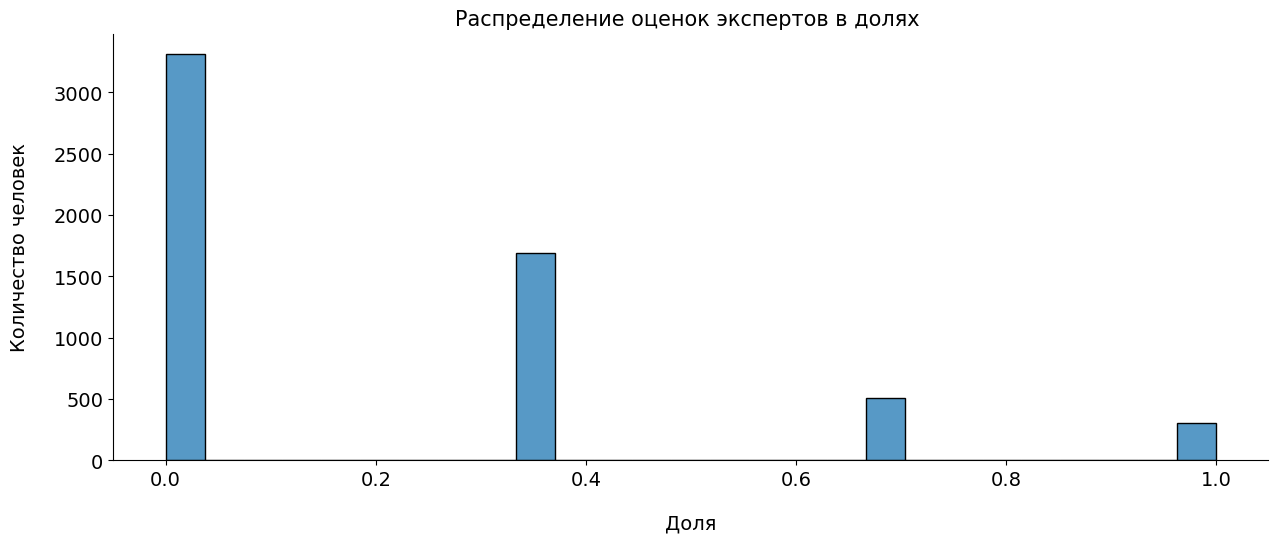

In [ ]:
plt_chart(expert_df_annot, 
          'mean_expert', 
          'Распределение оценок экспертов в долях ', 
          'Доля', 
          'Количество человек')

Большинство экспертов склоняется что изображение и запрос совершенно не соответствуют друг другу, в 2 раза меньше экспетов считают что запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует. И лишь небольшая часть экспертов подтвердила соответствие.

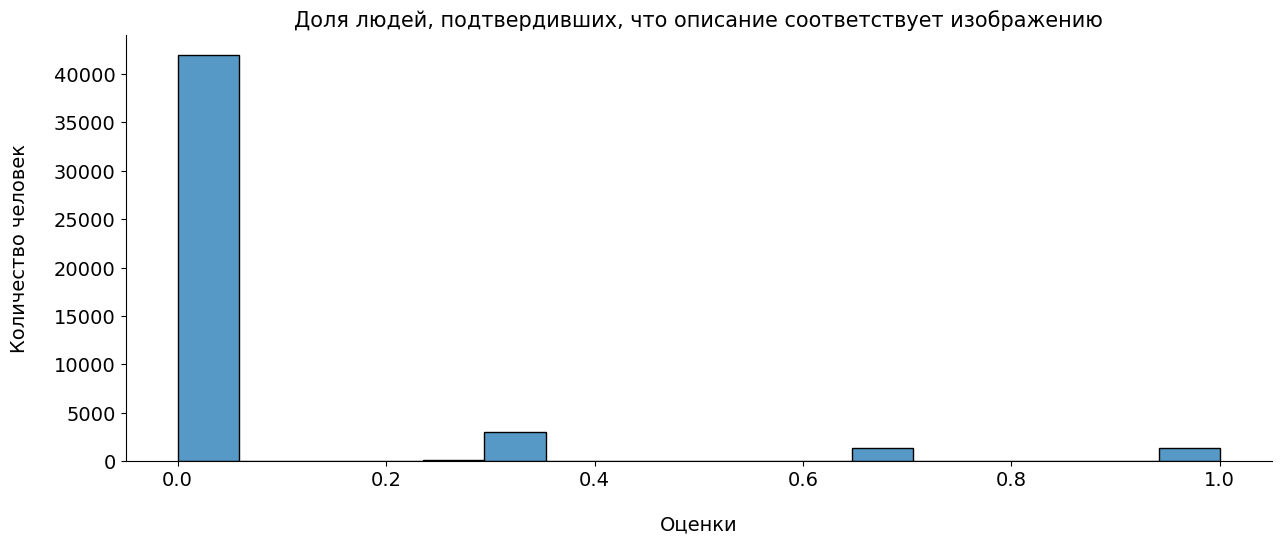

In [ ]:
plt_chart(crowd_df_annot, 
          'prop_people_image', 
          'Доля людей, подтвердивших, что описание соответствует изображению', 
          'Оценки', 
          'Количество человек')

Как в случае с экспертами, большинство людей подтвердивших, что описание не соответствует изображению. И лишь малая часть, высказалась наоборот. 

**Вывод**

Из всего выше сказанного, будем брать во внимание, оценки экспертов, т к оценки экспертов и людей приблизительно совпадают. Именно поэтому, возьмем оценки экспертов, потому-что они более квалифицированны, чем простые люди.

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
> 

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image             5822 non-null   object
 1   query_id          5822 non-null   object
 2   query_text_train  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


Было 5822 строк

In [ ]:
%%time
nlp = spacy.load('en_core_web_sm')

train_df["query_text"] = train_df['query_text_train'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x)]))
train_df.head(2)

CPU times: total: 23.7 s
Wall time: 23.8 s


,image,query_id,query_text_train,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,a young child be wear blue goggle and sit in a...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,a young child be wear blue goggle and sit in a...


Лемматизировали текст

In [ ]:
train_df = train_df.drop(['query_text_train'], axis=1)
train_df.head(3)

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...


Обработали описание картинок, а именно удалили лишние символы, лемматизировали, понизили регистр.

In [ ]:
new_train_df = train_df.copy()

stop_word_child = ['child', 
                   'newborn', 
                   'infant', 
                   'toddler', 
                   'kid', 
                   'baby', 
                   'pre teen', 
                   'adolescent', 
                   'teenager']

new_train_df['query_text'] = new_train_df['query_text'].str.lower()

new_train_df = new_train_df[new_train_df['query_text'].str.contains('|'.join(stop_word_child))==False].reset_index(drop=True)
new_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5278 entries, 0 to 5277
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5278 non-null   object
 1   query_id    5278 non-null   object
 2   query_text  5278 non-null   object
dtypes: object(3)
memory usage: 123.8+ KB


После фильтрации строк, стало 5326 строк.

**Вывод**

Отфильтровали наш обучающий df на наличие детей с помощью str.contains

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


Проверяем на наличие GPU

In [ ]:
def vector_img(path_img):
    
    # Загружаем претренированную модель:
    resnet = models.resnet18(pretrained=True) 
    
    # Мы не будем обучать модель, поэтому замораживаем веса:
    for param in resnet.parameters():
        param.requires_grad_(False) 
        
    # Берем все слои, кроме последнего:
    modules = list(resnet.children())[:-1]
    resnet = torch.nn.Sequential(*modules) 
    
    # Переводим модель в режим предсказания:
    resnet.eval();
    
    folder_dir = path_img

    # Изменяем размер картинки, вырезаем центр и нормализуем. 
    norm = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        norm
    ]) 


    tensor_img = []
    name_img = []

    # Считываем изображения с помощью glob, преобразовываем в 4-х мерный ввод:
    for images in glob.iglob(f'{folder_dir}/*'):

        if (images.endswith(".jpg")):
            file_name_images = os.path.basename(images)
            img = Image.open(images).convert('RGB')
            image_tensor = preprocess(img)
            input_batch = image_tensor.unsqueeze(0)

            input_batch = input_batch.to('cuda')
            resnet.to('cuda')

            with torch.no_grad():
                output_tensor = resnet(input_batch).flatten().cpu().numpy()

            tensor_img.append(output_tensor)
            name_img.append(file_name_images)
            
    name_img = pd.DataFrame(name_img, columns=['name_img'])
    tensor_img = pd.DataFrame(tensor_img)

    df_img = name_img.join(tensor_img)
    
    return df_img

Функция для векторизации изображений

In [ ]:
%%time
df_image = vector_img(patch_dir + 'train_images')
df_image.head(3)

C:\Users\seryo\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\seryo\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CPU times: total: 1min 41s
Wall time: 14.7 s


,name_img,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1056338697_4f7d7ce270.jpg,0.693983,3.031816,2.916985,0.951921,0.936227,1.245218,0.826550,1.108058,0.169696,...,0.444238,0.717754,0.294677,0.728790,1.153810,0.750845,1.196696,0.085011,1.056859,0.098236
1,106490881_5a2dd9b7bd.jpg,0.646340,1.727874,0.493905,0.652381,0.003698,1.045039,0.580451,1.886492,0.031211,...,0.140582,0.293088,0.901188,1.103395,1.974106,1.244866,0.286064,0.965043,4.713592,0.180931
2,1082379191_ec1e53f996.jpg,0.580884,0.636027,1.235306,1.239307,1.264693,0.385738,0.521415,1.737711,0.354156,...,0.707459,0.972237,0.291919,1.237113,0.270919,0.241003,0.039484,0.229986,2.469593,0.110243


**Вывод**

В данном разделе сделали векторизацию изображений с помощью модели ResNet-18.

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [ ]:
model_class, tokenizer_class, pretrained_weights = (transformers.BertModel, 
                                                    transformers.BertTokenizer, 
                                                    'bert-base-uncased')


tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Опытным путем было доказано, что bert-base-uncased в нашем случае показывает лучше результат, чем bert-base-cased. Поэтому загружаем предобученную модел bert-base-uncased и токенизатор.

In [ ]:
tokeniz = tokenizer_class.from_pretrained(pretrained_weights)

In [ ]:
%%time
token_lens_df_1 = []
for txt in new_train_df.query_text:
    tokens = tokeniz.encode(txt, max_length=512, truncation=True)
    token_lens_df_1.append(len(tokens))

CPU times: total: 1.34 s
Wall time: 1.34 s


In [ ]:
max(token_lens_df_1)

36

Максимальная длина токенов 36

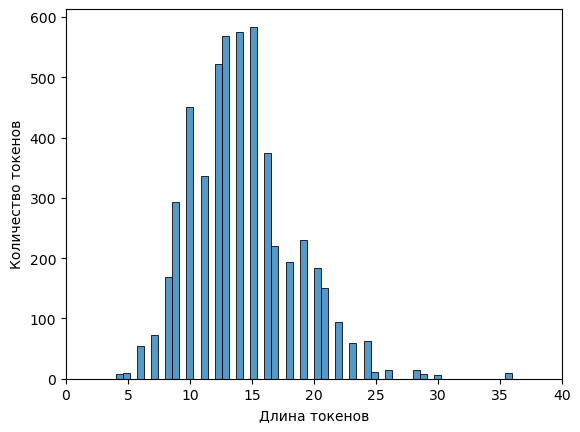

In [ ]:
sns.histplot(token_lens_df_1)
plt.xlim([0, 40]);
plt.ylabel('Количество токенов')
plt.xlabel('Длина токенов');

Большинство токенов длинной 9 - 17 слов

In [ ]:
model.to(device); 

Модель считаем на GPU, для ускорения выполнения кода.

In [ ]:
def text_emb(df_test):
    
    # Преобразуем каждое предложение в список идентификаторов:
    tokenized = df_test.apply((lambda x: tokenizer.encode(x, truncation = True, add_special_tokens=True)))
 

    # Применим метод padding, чтобы после токенизации длины исходных текстов в корпусе были равными:
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)
    padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
    
    
    # Поясним модели, что нули не несут значимой информации и укажем нулевые и не нулевые значения:
    attention_mask = np.where(padded != 0, 1, 0)
    
    
    batch_size = 1
    embeddings = []

    for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])                         # преобразуем данные
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])    # преобразуем маску

        with torch.no_grad():
            batch_embeddings = model(batch.to(device), attention_mask=attention_mask_batch.to(device))   # Чтобы получить эмбеддинги для батча, 
                                                                                   # передадим модели данные и маску

        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())             # Градиенты не нужны (увеличение скорости обучения)
 

    # Собираем все эмбеддинги в матрицу признаков вызовом функции concatenate:
    features_test = np.concatenate(embeddings)
    
    return features_test

Функция, для получения эмбенддинга

In [ ]:
%%time
features_emb = text_emb(new_train_df.query_text)

  0%|          | 0/5278 [00:00<?, ?it/s]

CPU times: total: 57.7 s
Wall time: 58.9 s


**Вывод**

В это разделе с помощью BERT выполнили обработку текста и собирали все эмбеддинги в матрицу признаков.

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [ ]:
text_train_df = pd.concat([new_train_df, pd.DataFrame(features_emb)], axis=1).drop(['query_text'], axis=1)
text_train_df.head(2)

,image,query_id,0,1,2,3,4,5,6,7,...,758,759,760,761,762,763,764,765,766,767
0,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,-0.146923,-0.098296,-0.734893,0.079753,-0.20247,0.020284,-0.001934,0.976893,...,-0.480427,-0.100147,0.069495,0.481844,0.366205,0.279139,-0.404139,-0.224082,0.415529,-0.151352
1,1167669558_87a8a467d6.jpg,2718495608_d8533e3ac5.jpg#2,-0.146923,-0.098296,-0.734893,0.079753,-0.20247,0.020284,-0.001934,0.976893,...,-0.480427,-0.100147,0.069495,0.481844,0.366205,0.279139,-0.404139,-0.224082,0.415529,-0.151352


Объединяем df с описанием картинок с векторами текстов.

In [ ]:
text_train_df = pd.merge(text_train_df, 
                         expert_df_annot, 
                         how='inner', 
                         left_on=['image', 'query_id'], 
                         right_on = ['name_image', 'id_image']).drop(['name_image',
                                                                      'id_image',
                                                                      'prop_people_image',
                                                                      'num_people_yes',
                                                                      'num_people_no'], axis=1)
text_train_df.head(2)

,image,query_id,0,1,2,3,4,5,6,7,...,759,760,761,762,763,764,765,766,767,mean_expert
0,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,-0.146923,-0.098296,-0.734893,0.079753,-0.20247,0.020284,-0.001934,0.976893,...,-0.100147,0.069495,0.481844,0.366205,0.279139,-0.404139,-0.224082,0.415529,-0.151352,0.000000
1,1167669558_87a8a467d6.jpg,2718495608_d8533e3ac5.jpg#2,-0.146923,-0.098296,-0.734893,0.079753,-0.20247,0.020284,-0.001934,0.976893,...,-0.100147,0.069495,0.481844,0.366205,0.279139,-0.404139,-0.224082,0.415529,-0.151352,0.333333


In [ ]:
text_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5278 entries, 0 to 5277
Columns: 771 entries, image to mean_expert
dtypes: float32(768), float64(1), object(2)
memory usage: 15.6+ MB


Объединяем df c векторами текстов и df с оценками

In [ ]:
text_train_df.insert(1, 'mean_expert', text_train_df.pop("mean_expert"))
text_train_df.head(3)

,image,mean_expert,query_id,0,1,2,3,4,5,6,...,758,759,760,761,762,763,764,765,766,767
0,1056338697_4f7d7ce270.jpg,0.000000,2718495608_d8533e3ac5.jpg#2,-0.146923,-0.098296,-0.734893,0.079753,-0.20247,0.020284,-0.001934,...,-0.480427,-0.100147,0.069495,0.481844,0.366205,0.279139,-0.404139,-0.224082,0.415529,-0.151352
1,1167669558_87a8a467d6.jpg,0.333333,2718495608_d8533e3ac5.jpg#2,-0.146923,-0.098296,-0.734893,0.079753,-0.20247,0.020284,-0.001934,...,-0.480427,-0.100147,0.069495,0.481844,0.366205,0.279139,-0.404139,-0.224082,0.415529,-0.151352
2,2616643090_4f2d2d1a44.jpg,0.000000,2718495608_d8533e3ac5.jpg#2,-0.146923,-0.098296,-0.734893,0.079753,-0.20247,0.020284,-0.001934,...,-0.480427,-0.100147,0.069495,0.481844,0.366205,0.279139,-0.404139,-0.224082,0.415529,-0.151352


Меняем местами слобцы для более удобной работы в дальнейшем.

In [ ]:
text_train_df = text_train_df.drop_duplicates().reset_index(drop=True)
text_train_df.head(2)

,image,mean_expert,query_id,0,1,2,3,4,5,6,...,758,759,760,761,762,763,764,765,766,767
0,1056338697_4f7d7ce270.jpg,0.000000,2718495608_d8533e3ac5.jpg#2,-0.146923,-0.098296,-0.734893,0.079753,-0.20247,0.020284,-0.001934,...,-0.480427,-0.100147,0.069495,0.481844,0.366205,0.279139,-0.404139,-0.224082,0.415529,-0.151352
1,1167669558_87a8a467d6.jpg,0.333333,2718495608_d8533e3ac5.jpg#2,-0.146923,-0.098296,-0.734893,0.079753,-0.20247,0.020284,-0.001934,...,-0.480427,-0.100147,0.069495,0.481844,0.366205,0.279139,-0.404139,-0.224082,0.415529,-0.151352


Удалили дубликаты после объединения df

In [ ]:
text_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5278 entries, 0 to 5277
Columns: 771 entries, image to 767
dtypes: float32(768), float64(1), object(2)
memory usage: 15.6+ MB


In [ ]:
final_train_df = pd.merge(text_train_df, 
                          df_image, 
                          how='inner', 
                          left_on='image', 
                          right_on = 'name_img').drop(['name_img', 'query_id'], axis=1)

In [ ]:
final_train_df

,image,mean_expert,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,502_y,503_y,504_y,505_y,506_y,507_y,508_y,509_y,510_y,511_y
0,1056338697_4f7d7ce270.jpg,0.000000,-0.146923,-0.098296,-0.734893,0.079753,-0.202470,0.020284,-0.001934,0.976893,...,0.444238,0.717754,0.294677,0.728790,1.153810,0.750845,1.196696,0.085011,1.056859,0.098236
1,1056338697_4f7d7ce270.jpg,0.000000,0.214542,-0.154829,-0.436712,0.247020,0.168189,-0.106164,-0.460836,0.983541,...,0.444238,0.717754,0.294677,0.728790,1.153810,0.750845,1.196696,0.085011,1.056859,0.098236
2,1056338697_4f7d7ce270.jpg,0.333333,0.153854,-0.000441,-0.727264,0.133459,0.034713,-0.096183,-0.332670,0.894699,...,0.444238,0.717754,0.294677,0.728790,1.153810,0.750845,1.196696,0.085011,1.056859,0.098236
3,1056338697_4f7d7ce270.jpg,0.000000,-0.368424,-0.235774,-0.305801,0.175350,0.182788,-0.073000,0.053588,1.238182,...,0.444238,0.717754,0.294677,0.728790,1.153810,0.750845,1.196696,0.085011,1.056859,0.098236
4,1056338697_4f7d7ce270.jpg,0.000000,-0.393511,-0.259616,-0.324264,0.051030,0.012449,-0.567379,0.141981,0.945651,...,0.444238,0.717754,0.294677,0.728790,1.153810,0.750845,1.196696,0.085011,1.056859,0.098236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5273,3544793763_b38546a5e8.jpg,1.000000,-0.465120,0.072564,-0.361008,-0.009103,-0.119952,-0.649714,0.856759,1.183462,...,0.625485,1.183846,1.377165,0.525169,0.091054,2.177594,0.935474,0.991106,1.878327,0.158235
5274,3544793763_b38546a5e8.jpg,0.333333,-0.474665,0.092876,-0.586897,-0.022766,0.048274,-0.325780,0.337572,0.489365,...,0.625485,1.183846,1.377165,0.525169,0.091054,2.177594,0.935474,0.991106,1.878327,0.158235
5275,2490768374_45d94fc658.jpg,0.333333,-0.020392,-0.011291,-0.192873,-0.044006,-0.183640,-0.173683,0.117003,0.447689,...,1.151326,0.455619,0.594367,1.112087,1.416027,1.140675,1.015754,0.443784,1.433377,0.415568
5276,2533424347_cf2f84872b.jpg,0.000000,-0.459326,0.079895,-0.571580,0.164616,0.472601,-0.440904,0.112929,1.008038,...,0.311627,1.192297,1.288276,0.454460,0.106916,1.890839,0.560171,1.340531,1.586802,1.210954


**Вывод**

В данном разделе мы соеденили в один df все таблицы нужные для обучения модели.

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=69)

train_indices, test_indices = next(gss.split(X=final_train_df.drop(columns=['image', 
                                                                            'mean_expert']), y=final_train_df['mean_expert'], groups=final_train_df['image']))

train_df, test_df = final_train_df.loc[train_indices], final_train_df.loc[test_indices]

Разбили df на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'image' будут содержаться либо в тестовом, либо в тренировочном df.

In [ ]:
train_df.head()

,image,mean_expert,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,502_y,503_y,504_y,505_y,506_y,507_y,508_y,509_y,510_y,511_y
0,1056338697_4f7d7ce270.jpg,0.000000,-0.146923,-0.098296,-0.734893,0.079753,-0.202470,0.020284,-0.001934,0.976893,...,0.444238,0.717754,0.294677,0.72879,1.15381,0.750845,1.196696,0.085011,1.056859,0.098236
1,1056338697_4f7d7ce270.jpg,0.000000,0.214542,-0.154829,-0.436712,0.247020,0.168189,-0.106164,-0.460836,0.983541,...,0.444238,0.717754,0.294677,0.72879,1.15381,0.750845,1.196696,0.085011,1.056859,0.098236
2,1056338697_4f7d7ce270.jpg,0.333333,0.153854,-0.000441,-0.727264,0.133459,0.034713,-0.096183,-0.332670,0.894699,...,0.444238,0.717754,0.294677,0.72879,1.15381,0.750845,1.196696,0.085011,1.056859,0.098236
3,1056338697_4f7d7ce270.jpg,0.000000,-0.368424,-0.235774,-0.305801,0.175350,0.182788,-0.073000,0.053588,1.238182,...,0.444238,0.717754,0.294677,0.72879,1.15381,0.750845,1.196696,0.085011,1.056859,0.098236
4,1056338697_4f7d7ce270.jpg,0.000000,-0.393511,-0.259616,-0.324264,0.051030,0.012449,-0.567379,0.141981,0.945651,...,0.444238,0.717754,0.294677,0.72879,1.15381,0.750845,1.196696,0.085011,1.056859,0.098236


In [ ]:
test_df.head()

,image,mean_expert,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,502_y,503_y,504_y,505_y,506_y,507_y,508_y,509_y,510_y,511_y
33,3503689049_63212220be.jpg,0.333333,-0.146923,-0.098296,-0.734893,0.079753,-0.202470,0.020284,-0.001934,0.976893,...,0.348071,0.076388,0.948682,0.678202,3.362858,0.070676,0.192586,0.311294,1.436595,0.621726
34,3503689049_63212220be.jpg,0.000000,-0.567184,0.212531,-1.093028,0.081582,0.090237,-0.246569,0.633614,0.859496,...,0.348071,0.076388,0.948682,0.678202,3.362858,0.070676,0.192586,0.311294,1.436595,0.621726
35,3503689049_63212220be.jpg,0.333333,0.237796,0.262013,-0.146163,-0.252631,0.145334,-0.119209,0.257634,0.570015,...,0.348071,0.076388,0.948682,0.678202,3.362858,0.070676,0.192586,0.311294,1.436595,0.621726
36,3503689049_63212220be.jpg,0.000000,-0.142021,-0.028543,-0.313990,0.389928,-0.694797,-0.335355,0.372792,1.108664,...,0.348071,0.076388,0.948682,0.678202,3.362858,0.070676,0.192586,0.311294,1.436595,0.621726
37,3503689049_63212220be.jpg,0.333333,-0.142879,0.250960,-0.446769,-0.314954,0.038797,-0.059647,0.017649,0.771410,...,0.348071,0.076388,0.948682,0.678202,3.362858,0.070676,0.192586,0.311294,1.436595,0.621726


In [ ]:
train_X = train_df.drop(columns=['image', 'mean_expert'], axis=1)
train_y = train_df['mean_expert']

test_X = test_df.drop(columns=['image', 'mean_expert'], axis=1)
test_y = test_df['mean_expert']

Сохранили в переменные нужные нам признаки

In [ ]:
train_X.head(2)

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,502_y,503_y,504_y,505_y,506_y,507_y,508_y,509_y,510_y,511_y
0,-0.146923,-0.098296,-0.734893,0.079753,-0.202470,0.020284,-0.001934,0.976893,-0.275856,-0.762272,...,0.444238,0.717754,0.294677,0.72879,1.15381,0.750845,1.196696,0.085011,1.056859,0.098236
1,0.214542,-0.154829,-0.436712,0.247020,0.168189,-0.106164,-0.460836,0.983541,-0.320723,-0.513129,...,0.444238,0.717754,0.294677,0.72879,1.15381,0.750845,1.196696,0.085011,1.056859,0.098236


Проверяем результат.

### CatBoostRegressor

In [ ]:
%%time
param = {'learning_rate': [0.001, 0.01, 0.1],
         'iterations' : [600, 900],
        }

model_cbr = CatBoostRegressor(loss_function = 'RMSE',
                              grow_policy = 'Lossguide',
                              custom_metric = 'RMSE', 
                              eval_metric = 'RMSE',
                              random_state = 69,
                              verbose = 100,
                              task_type="GPU",
                              devices='0:1')


search_random_1 = HalvingGridSearchCV(model_cbr, 
                                      param,      
                                      random_state=69, 
                                      cv=5, 
                                      scoring = 'neg_root_mean_squared_error').fit(train_X, 
                                                                                   train_y, 
                                                                                   eval_set=(test_X, test_y),
                                                                                   plot=False)
search_random_1.best_params_

0:	learn: 0.3009125	test: 0.2873303	best: 0.2873303 (0)	total: 27.5ms	remaining: 16.5s
100:	learn: 0.2891656	test: 0.2851781	best: 0.2851781 (100)	total: 2.41s	remaining: 11.9s
200:	learn: 0.2781078	test: 0.2833644	best: 0.2833644 (200)	total: 4.8s	remaining: 9.52s
300:	learn: 0.2676274	test: 0.2816809	best: 0.2816809 (300)	total: 7.04s	remaining: 7s
400:	learn: 0.2577738	test: 0.2802186	best: 0.2802186 (400)	total: 9.28s	remaining: 4.61s
500:	learn: 0.2486260	test: 0.2788788	best: 0.2788788 (500)	total: 11.7s	remaining: 2.32s
599:	learn: 0.2400314	test: 0.2777481	best: 0.2777481 (599)	total: 14.2s	remaining: 0us
bestTest = 0.2777481306
bestIteration = 599


0:	learn: 0.2993406	test: 0.2875455	best: 0.2875455 (0)	total: 30.9ms	remaining: 18.5s
100:	learn: 0.2876806	test: 0.2853957	best: 0.2853957 (100)	total: 2.41s	remaining: 11.9s
200:	learn: 0.2768461	test: 0.2835689	best: 0.2835689 (200)	total: 4.71s	remaining: 9.34s
300:	learn: 0.2665448	test: 0.2819695	best: 0.2819695 (300)	total: 7.1s	remaining: 7.05s
400:	learn: 0.2568176	test: 0.2805619	best: 0.2805619 (400)	total: 9.35s	remaining: 4.64s
500:	learn: 0.2476206	test: 0.2793507	best: 0.2793507 (500)	total: 11.8s	remaining: 2.33s
599:	learn: 0.2390675	test: 0.2782715	best: 0.2782715 (599)	total: 14.1s	remaining: 0us
bestTest = 0.2782715256
bestIteration = 599


0:	learn: 0.2987625	test: 0.2874802	best: 0.2874802 (0)	total: 30.4ms	remaining: 18.2s
100:	learn: 0.2877525	test: 0.2855415	best: 0.2855415 (100)	total: 2.46s	remaining: 12.1s
200:	learn: 0.2774006	test: 0.2838830	best: 0.2838830 (200)	total: 4.99s	remaining: 9.91s
300:	learn: 0.2674815	test: 0.2823871	best: 0.2823871 (300)	total: 7.4s	remaining: 7.35s
400:	learn: 0.2581825	test: 0.2811106	best: 0.2811106 (400)	total: 9.85s	remaining: 4.89s
500:	learn: 0.2494432	test: 0.2800085	best: 0.2800085 (500)	total: 12.1s	remaining: 2.39s
599:	learn: 0.2411922	test: 0.2790463	best: 0.2790463 (599)	total: 14.3s	remaining: 0us
bestTest = 0.2790462813
bestIteration = 599


0:	learn: 0.2862238	test: 0.2877871	best: 0.2877871 (0)	total: 27.8ms	remaining: 16.7s
100:	learn: 0.2761593	test: 0.2861831	best: 0.2861831 (100)	total: 2.42s	remaining: 11.9s
200:	learn: 0.2666654	test: 0.2847760	best: 0.2847760 (200)	total: 4.79s	remaining: 9.51s
300:	learn: 0.2577695	test: 0.2834636	best: 0.2834636 (300)	total: 7.13s	remaining: 7.08s
400:	learn: 0.2492041	test: 0.2822856	best: 0.2822856 (400)	total: 9.47s	remaining: 4.7s
500:	learn: 0.2411094	test: 0.2813133	best: 0.2813133 (500)	total: 11.8s	remaining: 2.34s
599:	learn: 0.2335496	test: 0.2803662	best: 0.2803662 (599)	total: 14.4s	remaining: 0us
bestTest = 0.2803661596
bestIteration = 599


0:	learn: 0.2914371	test: 0.2874699	best: 0.2874699 (0)	total: 26.9ms	remaining: 16.1s
100:	learn: 0.2798254	test: 0.2851109	best: 0.2851109 (100)	total: 2.32s	remaining: 11.5s
200:	learn: 0.2688968	test: 0.2830893	best: 0.2830893 (200)	total: 4.71s	remaining: 9.34s
300:	learn: 0.2585695	test: 0.2814405	best: 0.2814405 (300)	total: 6.97s	remaining: 6.92s
400:	learn: 0.2488344	test: 0.2798881	best: 0.2798881 (400)	total: 9.25s	remaining: 4.59s
500:	learn: 0.2397526	test: 0.2786468	best: 0.2786468 (500)	total: 11.6s	remaining: 2.29s
599:	learn: 0.2312539	test: 0.2775627	best: 0.2775627 (599)	total: 13.9s	remaining: 0us
bestTest = 0.2775626807
bestIteration = 599


0:	learn: 0.2997787	test: 0.2870664	best: 0.2870664 (0)	total: 27.6ms	remaining: 16.6s
100:	learn: 0.2086013	test: 0.2739999	best: 0.2739999 (100)	total: 2.41s	remaining: 11.9s
200:	learn: 0.1545235	test: 0.2698311	best: 0.2698311 (200)	total: 4.61s	remaining: 9.16s
300:	learn: 0.1189828	test: 0.2685082	best: 0.2685068 (299)	total: 6.79s	remaining: 6.75s
400:	learn: 0.0946449	test: 0.2680257	best: 0.2680257 (400)	total: 8.89s	remaining: 4.41s
500:	learn: 0.0763128	test: 0.2676759	best: 0.2676667 (499)	total: 11s	remaining: 2.17s
599:	learn: 0.0625202	test: 0.2675573	best: 0.2675511 (581)	total: 13.1s	remaining: 0us
bestTest = 0.2675510545
bestIteration = 581
Shrink model to first 582 iterations.


0:	learn: 0.2981407	test: 0.2873837	best: 0.2873837 (0)	total: 30.3ms	remaining: 18.1s
100:	learn: 0.2077311	test: 0.2746342	best: 0.2746342 (100)	total: 2.31s	remaining: 11.4s
200:	learn: 0.1531723	test: 0.2708858	best: 0.2708858 (200)	total: 4.51s	remaining: 8.94s
300:	learn: 0.1164895	test: 0.2694650	best: 0.2694609 (297)	total: 6.67s	remaining: 6.63s
400:	learn: 0.0921219	test: 0.2690227	best: 0.2689502 (377)	total: 8.76s	remaining: 4.35s
500:	learn: 0.0737029	test: 0.2687761	best: 0.2687249 (479)	total: 10.8s	remaining: 2.14s
599:	learn: 0.0597208	test: 0.2687342	best: 0.2686948 (581)	total: 12.9s	remaining: 0us
bestTest = 0.268694759
bestIteration = 581
Shrink model to first 582 iterations.


0:	learn: 0.2976751	test: 0.2872240	best: 0.2872240 (0)	total: 35.3ms	remaining: 21.1s
100:	learn: 0.2118791	test: 0.2760506	best: 0.2760506 (100)	total: 2.33s	remaining: 11.5s
200:	learn: 0.1580489	test: 0.2730502	best: 0.2730502 (200)	total: 4.69s	remaining: 9.32s
300:	learn: 0.1211618	test: 0.2716667	best: 0.2716667 (300)	total: 6.84s	remaining: 6.79s
400:	learn: 0.0958224	test: 0.2711254	best: 0.2710429 (379)	total: 9.01s	remaining: 4.47s
500:	learn: 0.0772047	test: 0.2708563	best: 0.2708097 (487)	total: 11.2s	remaining: 2.21s
599:	learn: 0.0633956	test: 0.2708558	best: 0.2707971 (586)	total: 13.3s	remaining: 0us
bestTest = 0.2707971278
bestIteration = 586
Shrink model to first 587 iterations.


0:	learn: 0.2853238	test: 0.2876207	best: 0.2876207 (0)	total: 27.2ms	remaining: 16.3s
100:	learn: 0.2053680	test: 0.2764240	best: 0.2764240 (100)	total: 2.24s	remaining: 11.1s
200:	learn: 0.1551356	test: 0.2732397	best: 0.2732397 (200)	total: 4.36s	remaining: 8.65s
300:	learn: 0.1200801	test: 0.2712869	best: 0.2712869 (300)	total: 6.42s	remaining: 6.38s
400:	learn: 0.0947432	test: 0.2705833	best: 0.2705778 (399)	total: 8.51s	remaining: 4.22s
500:	learn: 0.0754790	test: 0.2703729	best: 0.2703594 (499)	total: 10.6s	remaining: 2.09s
599:	learn: 0.0618118	test: 0.2702598	best: 0.2702598 (599)	total: 12.6s	remaining: 0us
bestTest = 0.2702597671
bestIteration = 599


0:	learn: 0.2902546	test: 0.2872358	best: 0.2872358 (0)	total: 25ms	remaining: 15s
100:	learn: 0.2003200	test: 0.2745323	best: 0.2745323 (100)	total: 2.43s	remaining: 12s
200:	learn: 0.1462024	test: 0.2715477	best: 0.2715477 (200)	total: 4.74s	remaining: 9.4s
300:	learn: 0.1095119	test: 0.2709637	best: 0.2709270 (297)	total: 7.01s	remaining: 6.96s
400:	learn: 0.0850871	test: 0.2706932	best: 0.2706517 (397)	total: 9.22s	remaining: 4.58s
500:	learn: 0.0671145	test: 0.2705973	best: 0.2705743 (490)	total: 11.4s	remaining: 2.26s
599:	learn: 0.0540957	test: 0.2706133	best: 0.2705429 (512)	total: 13.5s	remaining: 0us
bestTest = 0.270542909
bestIteration = 512
Shrink model to first 513 iterations.


0:	learn: 0.2886899	test: 0.2848987	best: 0.2848987 (0)	total: 26.3ms	remaining: 15.7s
100:	learn: 0.0323592	test: 0.2708112	best: 0.2705623 (89)	total: 2.13s	remaining: 10.5s
200:	learn: 0.0065227	test: 0.2711184	best: 0.2705623 (89)	total: 4.28s	remaining: 8.49s
300:	learn: 0.0016504	test: 0.2711336	best: 0.2705623 (89)	total: 6.43s	remaining: 6.39s
400:	learn: 0.0004676	test: 0.2711378	best: 0.2705623 (89)	total: 8.56s	remaining: 4.25s
500:	learn: 0.0001237	test: 0.2711359	best: 0.2705623 (89)	total: 10.7s	remaining: 2.11s
599:	learn: 0.0000331	test: 0.2711363	best: 0.2705623 (89)	total: 12.8s	remaining: 0us
bestTest = 0.2705623094
bestIteration = 89
Shrink model to first 90 iterations.


0:	learn: 0.2863925	test: 0.2862491	best: 0.2862491 (0)	total: 29.9ms	remaining: 17.9s
100:	learn: 0.0264843	test: 0.2761280	best: 0.2759210 (71)	total: 2.24s	remaining: 11s
200:	learn: 0.0050057	test: 0.2762732	best: 0.2759210 (71)	total: 4.49s	remaining: 8.92s
300:	learn: 0.0012073	test: 0.2762725	best: 0.2759210 (71)	total: 6.56s	remaining: 6.51s
400:	learn: 0.0002880	test: 0.2762701	best: 0.2759210 (71)	total: 8.7s	remaining: 4.32s
500:	learn: 0.0000713	test: 0.2762672	best: 0.2759210 (71)	total: 10.8s	remaining: 2.13s
599:	learn: 0.0000178	test: 0.2762667	best: 0.2759210 (71)	total: 12.9s	remaining: 0us
bestTest = 0.2759210472
bestIteration = 71
Shrink model to first 72 iterations.


0:	learn: 0.2870453	test: 0.2851104	best: 0.2851104 (0)	total: 29.6ms	remaining: 17.8s
100:	learn: 0.0295958	test: 0.2757489	best: 0.2747805 (18)	total: 2.12s	remaining: 10.5s
200:	learn: 0.0060978	test: 0.2757150	best: 0.2747805 (18)	total: 4.18s	remaining: 8.31s
300:	learn: 0.0013341	test: 0.2757282	best: 0.2747805 (18)	total: 6.25s	remaining: 6.21s
400:	learn: 0.0003108	test: 0.2757399	best: 0.2747805 (18)	total: 8.32s	remaining: 4.13s
500:	learn: 0.0000883	test: 0.2757412	best: 0.2747805 (18)	total: 10.4s	remaining: 2.05s
599:	learn: 0.0000218	test: 0.2757409	best: 0.2747805 (18)	total: 12.5s	remaining: 0us
bestTest = 0.274780516
bestIteration = 18
Shrink model to first 19 iterations.


0:	learn: 0.2765346	test: 0.2863495	best: 0.2863495 (0)	total: 33.1ms	remaining: 19.8s
100:	learn: 0.0302733	test: 0.2745196	best: 0.2739671 (69)	total: 2.24s	remaining: 11.1s
200:	learn: 0.0059388	test: 0.2745085	best: 0.2739671 (69)	total: 4.3s	remaining: 8.55s
300:	learn: 0.0012763	test: 0.2745989	best: 0.2739671 (69)	total: 6.37s	remaining: 6.33s
400:	learn: 0.0003022	test: 0.2745947	best: 0.2739671 (69)	total: 8.5s	remaining: 4.22s
500:	learn: 0.0000737	test: 0.2745952	best: 0.2739671 (69)	total: 10.7s	remaining: 2.12s
599:	learn: 0.0000196	test: 0.2745951	best: 0.2739671 (69)	total: 12.8s	remaining: 0us
bestTest = 0.2739671298
bestIteration = 69
Shrink model to first 70 iterations.


0:	learn: 0.2786875	test: 0.2853727	best: 0.2853727 (0)	total: 26.6ms	remaining: 15.9s
100:	learn: 0.0246443	test: 0.2768291	best: 0.2761706 (15)	total: 2.22s	remaining: 11s
200:	learn: 0.0052553	test: 0.2766233	best: 0.2761706 (15)	total: 4.29s	remaining: 8.52s
300:	learn: 0.0012387	test: 0.2766701	best: 0.2761706 (15)	total: 6.34s	remaining: 6.3s
400:	learn: 0.0003158	test: 0.2766725	best: 0.2761706 (15)	total: 8.46s	remaining: 4.2s
500:	learn: 0.0000776	test: 0.2766711	best: 0.2761706 (15)	total: 10.6s	remaining: 2.08s
599:	learn: 0.0000199	test: 0.2766712	best: 0.2761706 (15)	total: 12.6s	remaining: 0us
bestTest = 0.2761706039
bestIteration = 15
Shrink model to first 16 iterations.


0:	learn: 0.3009125	test: 0.2873303	best: 0.2873303 (0)	total: 26.1ms	remaining: 23.4s
100:	learn: 0.2891656	test: 0.2851781	best: 0.2851781 (100)	total: 2.49s	remaining: 19.7s
200:	learn: 0.2781078	test: 0.2833644	best: 0.2833644 (200)	total: 4.77s	remaining: 16.6s
300:	learn: 0.2676274	test: 0.2816809	best: 0.2816809 (300)	total: 7.15s	remaining: 14.2s
400:	learn: 0.2577738	test: 0.2802186	best: 0.2802186 (400)	total: 9.52s	remaining: 11.8s
500:	learn: 0.2486260	test: 0.2788788	best: 0.2788788 (500)	total: 11.9s	remaining: 9.46s
600:	learn: 0.2399344	test: 0.2777366	best: 0.2777366 (600)	total: 14.2s	remaining: 7.09s
700:	learn: 0.2317085	test: 0.2767334	best: 0.2767334 (700)	total: 16.6s	remaining: 4.71s
800:	learn: 0.2238674	test: 0.2757749	best: 0.2757749 (800)	total: 18.9s	remaining: 2.34s
899:	learn: 0.2164161	test: 0.2749180	best: 0.2749180 (899)	total: 21.2s	remaining: 0us
bestTest = 0.2749180082
bestIteration = 899


0:	learn: 0.2993406	test: 0.2875455	best: 0.2875455 (0)	total: 30ms	remaining: 27s
100:	learn: 0.2876806	test: 0.2853957	best: 0.2853957 (100)	total: 2.39s	remaining: 18.9s
200:	learn: 0.2768461	test: 0.2835689	best: 0.2835689 (200)	total: 4.74s	remaining: 16.5s
300:	learn: 0.2665448	test: 0.2819695	best: 0.2819695 (300)	total: 7.11s	remaining: 14.2s
400:	learn: 0.2568176	test: 0.2805619	best: 0.2805619 (400)	total: 9.35s	remaining: 11.6s
500:	learn: 0.2476206	test: 0.2793507	best: 0.2793507 (500)	total: 11.6s	remaining: 9.23s
600:	learn: 0.2389716	test: 0.2782520	best: 0.2782520 (600)	total: 13.8s	remaining: 6.88s
700:	learn: 0.2309060	test: 0.2773310	best: 0.2773310 (700)	total: 16.1s	remaining: 4.56s
800:	learn: 0.2230803	test: 0.2765000	best: 0.2765000 (800)	total: 18.3s	remaining: 2.26s
899:	learn: 0.2158315	test: 0.2758625	best: 0.2758625 (899)	total: 20.5s	remaining: 0us
bestTest = 0.2758625284
bestIteration = 899


0:	learn: 0.2987625	test: 0.2874802	best: 0.2874802 (0)	total: 28.9ms	remaining: 25.9s
100:	learn: 0.2877525	test: 0.2855415	best: 0.2855415 (100)	total: 2.38s	remaining: 18.8s
200:	learn: 0.2774006	test: 0.2838830	best: 0.2838830 (200)	total: 4.73s	remaining: 16.4s
300:	learn: 0.2674815	test: 0.2823871	best: 0.2823871 (300)	total: 6.99s	remaining: 13.9s
400:	learn: 0.2581825	test: 0.2811106	best: 0.2811106 (400)	total: 9.21s	remaining: 11.5s
500:	learn: 0.2494432	test: 0.2800085	best: 0.2800085 (500)	total: 11.4s	remaining: 9.1s
600:	learn: 0.2411113	test: 0.2790422	best: 0.2790422 (600)	total: 13.7s	remaining: 6.79s
700:	learn: 0.2333752	test: 0.2781065	best: 0.2781065 (700)	total: 15.8s	remaining: 4.5s
800:	learn: 0.2258718	test: 0.2773669	best: 0.2773669 (800)	total: 18s	remaining: 2.23s
899:	learn: 0.2188583	test: 0.2766453	best: 0.2766453 (899)	total: 20.2s	remaining: 0us
bestTest = 0.2766453135
bestIteration = 899


0:	learn: 0.2862238	test: 0.2877871	best: 0.2877871 (0)	total: 27.8ms	remaining: 25s
100:	learn: 0.2761593	test: 0.2861831	best: 0.2861831 (100)	total: 2.27s	remaining: 17.9s
200:	learn: 0.2666654	test: 0.2847760	best: 0.2847760 (200)	total: 4.5s	remaining: 15.7s
300:	learn: 0.2577695	test: 0.2834636	best: 0.2834636 (300)	total: 6.7s	remaining: 13.3s
400:	learn: 0.2492041	test: 0.2822856	best: 0.2822856 (400)	total: 8.89s	remaining: 11.1s
500:	learn: 0.2411094	test: 0.2813133	best: 0.2813133 (500)	total: 11.1s	remaining: 8.87s
600:	learn: 0.2334754	test: 0.2803636	best: 0.2803636 (600)	total: 13.5s	remaining: 6.71s
700:	learn: 0.2262650	test: 0.2795156	best: 0.2795156 (700)	total: 15.8s	remaining: 4.47s
800:	learn: 0.2194033	test: 0.2787626	best: 0.2787626 (800)	total: 18s	remaining: 2.22s
899:	learn: 0.2128610	test: 0.2780594	best: 0.2780594 (899)	total: 20.1s	remaining: 0us
bestTest = 0.2780593614
bestIteration = 899


0:	learn: 0.2914371	test: 0.2874699	best: 0.2874699 (0)	total: 26.4ms	remaining: 23.7s
100:	learn: 0.2798254	test: 0.2851109	best: 0.2851109 (100)	total: 2.43s	remaining: 19.2s
200:	learn: 0.2688968	test: 0.2830893	best: 0.2830893 (200)	total: 4.84s	remaining: 16.8s
300:	learn: 0.2585695	test: 0.2814405	best: 0.2814405 (300)	total: 7.25s	remaining: 14.4s
400:	learn: 0.2488344	test: 0.2798881	best: 0.2798881 (400)	total: 9.65s	remaining: 12s
500:	learn: 0.2397526	test: 0.2786468	best: 0.2786468 (500)	total: 12.1s	remaining: 9.61s
600:	learn: 0.2311770	test: 0.2775578	best: 0.2775578 (600)	total: 14.5s	remaining: 7.2s
700:	learn: 0.2231205	test: 0.2766384	best: 0.2766384 (700)	total: 16.9s	remaining: 4.79s
800:	learn: 0.2152748	test: 0.2758437	best: 0.2758437 (800)	total: 19.3s	remaining: 2.38s
899:	learn: 0.2079560	test: 0.2751705	best: 0.2751700 (898)	total: 21.5s	remaining: 0us
bestTest = 0.2751699662
bestIteration = 898
Shrink model to first 899 iterations.


0:	learn: 0.2997787	test: 0.2870664	best: 0.2870664 (0)	total: 27.2ms	remaining: 24.5s
100:	learn: 0.2086013	test: 0.2739999	best: 0.2739999 (100)	total: 2.39s	remaining: 18.9s
200:	learn: 0.1545235	test: 0.2698311	best: 0.2698311 (200)	total: 4.57s	remaining: 15.9s
300:	learn: 0.1189828	test: 0.2685082	best: 0.2685068 (299)	total: 6.77s	remaining: 13.5s
400:	learn: 0.0946449	test: 0.2680257	best: 0.2680257 (400)	total: 8.99s	remaining: 11.2s
500:	learn: 0.0763128	test: 0.2676759	best: 0.2676667 (499)	total: 11.1s	remaining: 8.83s
600:	learn: 0.0624152	test: 0.2675414	best: 0.2675414 (600)	total: 13.2s	remaining: 6.55s
700:	learn: 0.0512530	test: 0.2675396	best: 0.2675063 (615)	total: 15.4s	remaining: 4.36s
800:	learn: 0.0426258	test: 0.2675018	best: 0.2674533 (773)	total: 17.5s	remaining: 2.17s
899:	learn: 0.0355828	test: 0.2674959	best: 0.2674485 (852)	total: 19.7s	remaining: 0us
bestTest = 0.2674484778
bestIteration = 852
Shrink model to first 853 iterations.


0:	learn: 0.2981407	test: 0.2873837	best: 0.2873837 (0)	total: 29.6ms	remaining: 26.6s
100:	learn: 0.2077311	test: 0.2746342	best: 0.2746342 (100)	total: 2.24s	remaining: 17.7s
200:	learn: 0.1531723	test: 0.2708858	best: 0.2708858 (200)	total: 4.42s	remaining: 15.4s
300:	learn: 0.1164895	test: 0.2694650	best: 0.2694609 (297)	total: 6.53s	remaining: 13s
400:	learn: 0.0921219	test: 0.2690227	best: 0.2689502 (377)	total: 8.6s	remaining: 10.7s
500:	learn: 0.0737029	test: 0.2687761	best: 0.2687249 (479)	total: 10.7s	remaining: 8.48s
600:	learn: 0.0595354	test: 0.2687302	best: 0.2686948 (581)	total: 12.7s	remaining: 6.33s
700:	learn: 0.0484896	test: 0.2687134	best: 0.2686933 (625)	total: 14.8s	remaining: 4.19s
800:	learn: 0.0397081	test: 0.2687123	best: 0.2686874 (776)	total: 16.9s	remaining: 2.08s
899:	learn: 0.0330378	test: 0.2687564	best: 0.2686874 (776)	total: 18.9s	remaining: 0us
bestTest = 0.2686873728
bestIteration = 776
Shrink model to first 777 iterations.


0:	learn: 0.2976751	test: 0.2872240	best: 0.2872240 (0)	total: 29.4ms	remaining: 26.4s
100:	learn: 0.2118791	test: 0.2760506	best: 0.2760506 (100)	total: 2.3s	remaining: 18.2s
200:	learn: 0.1580489	test: 0.2730502	best: 0.2730502 (200)	total: 4.52s	remaining: 15.7s
300:	learn: 0.1211618	test: 0.2716667	best: 0.2716667 (300)	total: 6.66s	remaining: 13.3s
400:	learn: 0.0958224	test: 0.2711254	best: 0.2710429 (379)	total: 8.75s	remaining: 10.9s
500:	learn: 0.0772047	test: 0.2708563	best: 0.2708097 (487)	total: 10.8s	remaining: 8.63s
600:	learn: 0.0633110	test: 0.2708535	best: 0.2707971 (586)	total: 12.9s	remaining: 6.4s
700:	learn: 0.0524291	test: 0.2708227	best: 0.2707971 (586)	total: 14.9s	remaining: 4.22s
800:	learn: 0.0439739	test: 0.2708727	best: 0.2707971 (586)	total: 17.2s	remaining: 2.12s
899:	learn: 0.0371477	test: 0.2709738	best: 0.2707971 (586)	total: 19.2s	remaining: 0us
bestTest = 0.2707971278
bestIteration = 586
Shrink model to first 587 iterations.


0:	learn: 0.2853238	test: 0.2876207	best: 0.2876207 (0)	total: 26.9ms	remaining: 24.2s
100:	learn: 0.2053680	test: 0.2764240	best: 0.2764240 (100)	total: 2.31s	remaining: 18.3s
200:	learn: 0.1551356	test: 0.2732397	best: 0.2732397 (200)	total: 4.49s	remaining: 15.6s
300:	learn: 0.1200801	test: 0.2712869	best: 0.2712869 (300)	total: 6.57s	remaining: 13.1s
400:	learn: 0.0947432	test: 0.2705833	best: 0.2705778 (399)	total: 8.78s	remaining: 10.9s
500:	learn: 0.0754790	test: 0.2703729	best: 0.2703594 (499)	total: 11s	remaining: 8.73s
600:	learn: 0.0616938	test: 0.2702577	best: 0.2702577 (600)	total: 13.2s	remaining: 6.55s
700:	learn: 0.0506564	test: 0.2701717	best: 0.2701444 (655)	total: 15.5s	remaining: 4.4s
800:	learn: 0.0422061	test: 0.2701517	best: 0.2701444 (655)	total: 17.5s	remaining: 2.16s
899:	learn: 0.0357651	test: 0.2701174	best: 0.2701127 (859)	total: 19.6s	remaining: 0us
bestTest = 0.2701127443
bestIteration = 859
Shrink model to first 860 iterations.


0:	learn: 0.2902546	test: 0.2872358	best: 0.2872358 (0)	total: 27.9ms	remaining: 25.1s
100:	learn: 0.2003200	test: 0.2745323	best: 0.2745323 (100)	total: 2.4s	remaining: 19s
200:	learn: 0.1462024	test: 0.2715477	best: 0.2715477 (200)	total: 4.72s	remaining: 16.4s
300:	learn: 0.1095119	test: 0.2709637	best: 0.2709270 (297)	total: 6.88s	remaining: 13.7s
400:	learn: 0.0850871	test: 0.2706932	best: 0.2706517 (397)	total: 8.97s	remaining: 11.2s
500:	learn: 0.0671145	test: 0.2705973	best: 0.2705743 (490)	total: 11.1s	remaining: 8.84s
600:	learn: 0.0539416	test: 0.2706001	best: 0.2705429 (512)	total: 13.3s	remaining: 6.63s
700:	learn: 0.0436824	test: 0.2705104	best: 0.2705049 (699)	total: 15.6s	remaining: 4.42s
800:	learn: 0.0359494	test: 0.2704443	best: 0.2704356 (770)	total: 17.8s	remaining: 2.2s
899:	learn: 0.0302239	test: 0.2704264	best: 0.2703737 (826)	total: 19.9s	remaining: 0us
bestTest = 0.2703736631
bestIteration = 826
Shrink model to first 827 iterations.


0:	learn: 0.2886899	test: 0.2848987	best: 0.2848987 (0)	total: 27.2ms	remaining: 24.5s
100:	learn: 0.0323592	test: 0.2708112	best: 0.2705623 (89)	total: 2.21s	remaining: 17.5s
200:	learn: 0.0065227	test: 0.2711184	best: 0.2705623 (89)	total: 4.28s	remaining: 14.9s
300:	learn: 0.0016504	test: 0.2711336	best: 0.2705623 (89)	total: 6.34s	remaining: 12.6s
400:	learn: 0.0004676	test: 0.2711378	best: 0.2705623 (89)	total: 8.38s	remaining: 10.4s
500:	learn: 0.0001237	test: 0.2711359	best: 0.2705623 (89)	total: 10.4s	remaining: 8.29s
600:	learn: 0.0000329	test: 0.2711363	best: 0.2705623 (89)	total: 12.6s	remaining: 6.25s
700:	learn: 0.0000089	test: 0.2711365	best: 0.2705623 (89)	total: 14.7s	remaining: 4.17s
800:	learn: 0.0000023	test: 0.2711364	best: 0.2705623 (89)	total: 16.7s	remaining: 2.07s
899:	learn: 0.0000007	test: 0.2711365	best: 0.2705623 (89)	total: 18.8s	remaining: 0us
bestTest = 0.2705623094
bestIteration = 89
Shrink model to first 90 iterations.


0:	learn: 0.2863925	test: 0.2862491	best: 0.2862491 (0)	total: 29.6ms	remaining: 26.6s
100:	learn: 0.0264843	test: 0.2761280	best: 0.2759210 (71)	total: 2.21s	remaining: 17.5s
200:	learn: 0.0050057	test: 0.2762732	best: 0.2759210 (71)	total: 4.28s	remaining: 14.9s
300:	learn: 0.0012073	test: 0.2762725	best: 0.2759210 (71)	total: 6.32s	remaining: 12.6s
400:	learn: 0.0002880	test: 0.2762701	best: 0.2759210 (71)	total: 8.43s	remaining: 10.5s
500:	learn: 0.0000713	test: 0.2762672	best: 0.2759210 (71)	total: 10.5s	remaining: 8.33s
600:	learn: 0.0000177	test: 0.2762668	best: 0.2759210 (71)	total: 12.5s	remaining: 6.23s
700:	learn: 0.0000050	test: 0.2762668	best: 0.2759210 (71)	total: 14.6s	remaining: 4.13s
800:	learn: 0.0000013	test: 0.2762667	best: 0.2759210 (71)	total: 16.6s	remaining: 2.05s
899:	learn: 0.0000004	test: 0.2762667	best: 0.2759210 (71)	total: 18.6s	remaining: 0us
bestTest = 0.2759210472
bestIteration = 71
Shrink model to first 72 iterations.


0:	learn: 0.2870453	test: 0.2851104	best: 0.2851104 (0)	total: 28.5ms	remaining: 25.6s
100:	learn: 0.0295958	test: 0.2757489	best: 0.2747805 (18)	total: 2.1s	remaining: 16.6s
200:	learn: 0.0060978	test: 0.2757150	best: 0.2747805 (18)	total: 4.14s	remaining: 14.4s
300:	learn: 0.0013341	test: 0.2757282	best: 0.2747805 (18)	total: 6.2s	remaining: 12.3s
400:	learn: 0.0003108	test: 0.2757399	best: 0.2747805 (18)	total: 8.25s	remaining: 10.3s
500:	learn: 0.0000883	test: 0.2757412	best: 0.2747805 (18)	total: 10.2s	remaining: 8.14s
600:	learn: 0.0000214	test: 0.2757409	best: 0.2747805 (18)	total: 12.3s	remaining: 6.1s
700:	learn: 0.0000057	test: 0.2757408	best: 0.2747805 (18)	total: 14.3s	remaining: 4.06s
800:	learn: 0.0000015	test: 0.2757407	best: 0.2747805 (18)	total: 16.3s	remaining: 2.02s
899:	learn: 0.0000004	test: 0.2757407	best: 0.2747805 (18)	total: 18.3s	remaining: 0us
bestTest = 0.274780516
bestIteration = 18
Shrink model to first 19 iterations.


0:	learn: 0.2765346	test: 0.2863495	best: 0.2863495 (0)	total: 26.6ms	remaining: 23.9s
100:	learn: 0.0302733	test: 0.2745196	best: 0.2739671 (69)	total: 2.11s	remaining: 16.7s
200:	learn: 0.0059388	test: 0.2745085	best: 0.2739671 (69)	total: 4.18s	remaining: 14.5s
300:	learn: 0.0012763	test: 0.2745989	best: 0.2739671 (69)	total: 6.26s	remaining: 12.5s
400:	learn: 0.0003022	test: 0.2745947	best: 0.2739671 (69)	total: 8.34s	remaining: 10.4s
500:	learn: 0.0000737	test: 0.2745952	best: 0.2739671 (69)	total: 10.4s	remaining: 8.28s
600:	learn: 0.0000192	test: 0.2745951	best: 0.2739671 (69)	total: 12.4s	remaining: 6.18s
700:	learn: 0.0000048	test: 0.2745953	best: 0.2739671 (69)	total: 14.5s	remaining: 4.11s
800:	learn: 0.0000012	test: 0.2745953	best: 0.2739671 (69)	total: 16.5s	remaining: 2.04s
899:	learn: 0.0000003	test: 0.2745953	best: 0.2739671 (69)	total: 18.5s	remaining: 0us
bestTest = 0.2739671298
bestIteration = 69
Shrink model to first 70 iterations.


0:	learn: 0.2786875	test: 0.2853727	best: 0.2853727 (0)	total: 26.1ms	remaining: 23.4s
100:	learn: 0.0246443	test: 0.2768291	best: 0.2761706 (15)	total: 2.28s	remaining: 18.1s
200:	learn: 0.0052553	test: 0.2766233	best: 0.2761706 (15)	total: 4.46s	remaining: 15.5s
300:	learn: 0.0012387	test: 0.2766701	best: 0.2761706 (15)	total: 6.62s	remaining: 13.2s
400:	learn: 0.0003158	test: 0.2766725	best: 0.2761706 (15)	total: 8.74s	remaining: 10.9s
500:	learn: 0.0000776	test: 0.2766711	best: 0.2761706 (15)	total: 10.9s	remaining: 8.65s
600:	learn: 0.0000196	test: 0.2766712	best: 0.2761706 (15)	total: 12.9s	remaining: 6.41s
700:	learn: 0.0000054	test: 0.2766712	best: 0.2761706 (15)	total: 14.9s	remaining: 4.22s
800:	learn: 0.0000016	test: 0.2766712	best: 0.2761706 (15)	total: 16.9s	remaining: 2.09s
899:	learn: 0.0000004	test: 0.2766712	best: 0.2761706 (15)	total: 18.9s	remaining: 0us
bestTest = 0.2761706039
bestIteration = 15
Shrink model to first 16 iterations.


0:	learn: 0.2902295	test: 0.2874496	best: 0.2874496 (0)	total: 27.1ms	remaining: 24.3s
100:	learn: 0.2339238	test: 0.2702377	best: 0.2702377 (100)	total: 2.31s	remaining: 18.3s
200:	learn: 0.1995595	test: 0.2647585	best: 0.2647585 (200)	total: 4.58s	remaining: 15.9s
300:	learn: 0.1754685	test: 0.2626649	best: 0.2626649 (300)	total: 6.8s	remaining: 13.5s
400:	learn: 0.1566258	test: 0.2611845	best: 0.2611845 (400)	total: 9s	remaining: 11.2s
500:	learn: 0.1415488	test: 0.2601423	best: 0.2601423 (500)	total: 11.2s	remaining: 8.92s
600:	learn: 0.1290744	test: 0.2595236	best: 0.2595236 (600)	total: 13.4s	remaining: 6.65s
700:	learn: 0.1177141	test: 0.2589262	best: 0.2589226 (695)	total: 15.5s	remaining: 4.41s
800:	learn: 0.1076748	test: 0.2583776	best: 0.2583742 (799)	total: 17.7s	remaining: 2.19s
899:	learn: 0.0986550	test: 0.2579610	best: 0.2579569 (896)	total: 19.9s	remaining: 0us
bestTest = 0.2579568837
bestIteration = 896
Shrink model to first 897 iterations.


0:	learn: 0.2867182	test: 0.2875983	best: 0.2875983 (0)	total: 28.9ms	remaining: 26s
100:	learn: 0.2313240	test: 0.2684937	best: 0.2684937 (100)	total: 2.36s	remaining: 18.7s
200:	learn: 0.1981403	test: 0.2626296	best: 0.2626296 (200)	total: 4.63s	remaining: 16.1s
300:	learn: 0.1737839	test: 0.2602499	best: 0.2602499 (300)	total: 6.87s	remaining: 13.7s
400:	learn: 0.1552967	test: 0.2585979	best: 0.2585979 (400)	total: 9.08s	remaining: 11.3s
500:	learn: 0.1400243	test: 0.2572238	best: 0.2572238 (500)	total: 11.3s	remaining: 8.98s
600:	learn: 0.1274726	test: 0.2563888	best: 0.2563888 (600)	total: 13.5s	remaining: 6.72s
700:	learn: 0.1162352	test: 0.2554816	best: 0.2554816 (700)	total: 15.7s	remaining: 4.45s
800:	learn: 0.1065027	test: 0.2550522	best: 0.2550522 (800)	total: 17.8s	remaining: 2.21s
899:	learn: 0.0979957	test: 0.2546488	best: 0.2546488 (899)	total: 20.1s	remaining: 0us
bestTest = 0.254648816
bestIteration = 899


0:	learn: 0.2860566	test: 0.2877924	best: 0.2877924 (0)	total: 29.2ms	remaining: 26.3s
100:	learn: 0.2305339	test: 0.2691946	best: 0.2691946 (100)	total: 2.31s	remaining: 18.3s
200:	learn: 0.1973263	test: 0.2633104	best: 0.2633104 (200)	total: 4.54s	remaining: 15.8s
300:	learn: 0.1734864	test: 0.2604646	best: 0.2604646 (300)	total: 6.75s	remaining: 13.4s
400:	learn: 0.1550402	test: 0.2589639	best: 0.2589639 (400)	total: 8.93s	remaining: 11.1s
500:	learn: 0.1402128	test: 0.2582118	best: 0.2582059 (499)	total: 11.1s	remaining: 8.83s
600:	learn: 0.1275094	test: 0.2572742	best: 0.2572742 (600)	total: 13.2s	remaining: 6.59s
700:	learn: 0.1163406	test: 0.2568680	best: 0.2568680 (700)	total: 15.4s	remaining: 4.38s
800:	learn: 0.1064363	test: 0.2563968	best: 0.2563882 (797)	total: 17.6s	remaining: 2.17s
899:	learn: 0.0975946	test: 0.2559355	best: 0.2559292 (893)	total: 19.7s	remaining: 0us
bestTest = 0.2559292129
bestIteration = 893
Shrink model to first 894 iterations.


0:	learn: 0.2827814	test: 0.2878484	best: 0.2878484 (0)	total: 29.9ms	remaining: 26.9s
100:	learn: 0.2302390	test: 0.2708571	best: 0.2708571 (100)	total: 2.39s	remaining: 18.9s
200:	learn: 0.1974964	test: 0.2642195	best: 0.2642195 (200)	total: 4.62s	remaining: 16.1s
300:	learn: 0.1744161	test: 0.2609016	best: 0.2609016 (300)	total: 6.8s	remaining: 13.5s
400:	learn: 0.1558927	test: 0.2596480	best: 0.2596460 (396)	total: 8.98s	remaining: 11.2s
500:	learn: 0.1406904	test: 0.2584779	best: 0.2584779 (500)	total: 11.1s	remaining: 8.87s
600:	learn: 0.1279357	test: 0.2576738	best: 0.2576738 (600)	total: 13.4s	remaining: 6.65s
700:	learn: 0.1166522	test: 0.2570045	best: 0.2570045 (700)	total: 15.5s	remaining: 4.4s
800:	learn: 0.1068893	test: 0.2565423	best: 0.2565423 (800)	total: 17.7s	remaining: 2.18s
899:	learn: 0.0980541	test: 0.2562216	best: 0.2562190 (897)	total: 19.8s	remaining: 0us
bestTest = 0.2562189944
bestIteration = 897
Shrink model to first 898 iterations.


0:	learn: 0.2861748	test: 0.2874142	best: 0.2874142 (0)	total: 28.1ms	remaining: 25.2s
100:	learn: 0.2292082	test: 0.2687158	best: 0.2687158 (100)	total: 2.37s	remaining: 18.7s
200:	learn: 0.1946989	test: 0.2630081	best: 0.2630081 (200)	total: 4.64s	remaining: 16.1s
300:	learn: 0.1710455	test: 0.2602936	best: 0.2602936 (300)	total: 6.89s	remaining: 13.7s
400:	learn: 0.1524868	test: 0.2587689	best: 0.2587689 (400)	total: 9.33s	remaining: 11.6s
500:	learn: 0.1374251	test: 0.2578850	best: 0.2578666 (497)	total: 11.5s	remaining: 9.16s
600:	learn: 0.1246846	test: 0.2570758	best: 0.2570733 (599)	total: 13.7s	remaining: 6.8s
700:	learn: 0.1138194	test: 0.2563430	best: 0.2563430 (700)	total: 15.8s	remaining: 4.49s
800:	learn: 0.1041644	test: 0.2559377	best: 0.2559293 (799)	total: 18s	remaining: 2.22s
899:	learn: 0.0954652	test: 0.2556222	best: 0.2556222 (899)	total: 20.1s	remaining: 0us
bestTest = 0.2556221781
bestIteration = 899


0:	learn: 0.2902295	test: 0.2874496	best: 0.2874496 (0)	total: 28.9ms	remaining: 17.3s
100:	learn: 0.2339238	test: 0.2702377	best: 0.2702377 (100)	total: 2.46s	remaining: 12.2s
200:	learn: 0.1995595	test: 0.2647585	best: 0.2647585 (200)	total: 4.87s	remaining: 9.67s
300:	learn: 0.1754685	test: 0.2626649	best: 0.2626649 (300)	total: 7.25s	remaining: 7.2s
400:	learn: 0.1566258	test: 0.2611845	best: 0.2611845 (400)	total: 9.58s	remaining: 4.75s
500:	learn: 0.1415488	test: 0.2601423	best: 0.2601423 (500)	total: 11.8s	remaining: 2.34s
599:	learn: 0.1291802	test: 0.2595298	best: 0.2595298 (599)	total: 14s	remaining: 0us
bestTest = 0.259529812
bestIteration = 599


0:	learn: 0.2867182	test: 0.2875983	best: 0.2875983 (0)	total: 28.6ms	remaining: 17.1s
100:	learn: 0.2313240	test: 0.2684937	best: 0.2684937 (100)	total: 2.35s	remaining: 11.6s
200:	learn: 0.1981403	test: 0.2626296	best: 0.2626296 (200)	total: 4.62s	remaining: 9.16s
300:	learn: 0.1737839	test: 0.2602499	best: 0.2602499 (300)	total: 6.85s	remaining: 6.8s
400:	learn: 0.1552967	test: 0.2585979	best: 0.2585979 (400)	total: 9.03s	remaining: 4.48s
500:	learn: 0.1400243	test: 0.2572238	best: 0.2572238 (500)	total: 11.2s	remaining: 2.21s
599:	learn: 0.1276225	test: 0.2564115	best: 0.2564115 (599)	total: 13.4s	remaining: 0us
bestTest = 0.256411501
bestIteration = 599


0:	learn: 0.2860566	test: 0.2877924	best: 0.2877924 (0)	total: 30.4ms	remaining: 18.2s
100:	learn: 0.2305339	test: 0.2691946	best: 0.2691946 (100)	total: 2.36s	remaining: 11.7s
200:	learn: 0.1973263	test: 0.2633104	best: 0.2633104 (200)	total: 4.6s	remaining: 9.13s
300:	learn: 0.1734864	test: 0.2604646	best: 0.2604646 (300)	total: 6.81s	remaining: 6.76s
400:	learn: 0.1550402	test: 0.2589639	best: 0.2589639 (400)	total: 8.98s	remaining: 4.46s
500:	learn: 0.1402128	test: 0.2582118	best: 0.2582059 (499)	total: 11.1s	remaining: 2.2s
599:	learn: 0.1276303	test: 0.2572750	best: 0.2572749 (597)	total: 13.3s	remaining: 0us
bestTest = 0.2572748863
bestIteration = 597
Shrink model to first 598 iterations.


0:	learn: 0.2827814	test: 0.2878484	best: 0.2878484 (0)	total: 29.5ms	remaining: 17.7s
100:	learn: 0.2302390	test: 0.2708571	best: 0.2708571 (100)	total: 2.44s	remaining: 12s
200:	learn: 0.1974964	test: 0.2642195	best: 0.2642195 (200)	total: 4.81s	remaining: 9.54s
300:	learn: 0.1744161	test: 0.2609016	best: 0.2609016 (300)	total: 7.1s	remaining: 7.05s
400:	learn: 0.1558927	test: 0.2596480	best: 0.2596460 (396)	total: 9.28s	remaining: 4.6s
500:	learn: 0.1406904	test: 0.2584779	best: 0.2584779 (500)	total: 11.4s	remaining: 2.26s
599:	learn: 0.1280602	test: 0.2576798	best: 0.2576798 (599)	total: 13.6s	remaining: 0us
bestTest = 0.2576798133
bestIteration = 599


0:	learn: 0.2861748	test: 0.2874142	best: 0.2874142 (0)	total: 26.1ms	remaining: 15.6s
100:	learn: 0.2292082	test: 0.2687158	best: 0.2687158 (100)	total: 2.34s	remaining: 11.6s
200:	learn: 0.1946989	test: 0.2630081	best: 0.2630081 (200)	total: 4.61s	remaining: 9.16s
300:	learn: 0.1710455	test: 0.2602936	best: 0.2602936 (300)	total: 6.84s	remaining: 6.8s
400:	learn: 0.1524868	test: 0.2587689	best: 0.2587689 (400)	total: 9.06s	remaining: 4.5s
500:	learn: 0.1374251	test: 0.2578850	best: 0.2578666 (497)	total: 11.2s	remaining: 2.22s
599:	learn: 0.1247621	test: 0.2570733	best: 0.2570733 (599)	total: 13.4s	remaining: 0us
bestTest = 0.2570733435
bestIteration = 599


0:	learn: 0.2864300	test: 0.2876464	best: 0.2876464 (0)	total: 29.1ms	remaining: 26.2s
100:	learn: 0.2370043	test: 0.2686548	best: 0.2686548 (100)	total: 2.35s	remaining: 18.6s
200:	learn: 0.2062501	test: 0.2621943	best: 0.2621943 (200)	total: 4.65s	remaining: 16.2s
300:	learn: 0.1845700	test: 0.2593952	best: 0.2593952 (300)	total: 6.88s	remaining: 13.7s
400:	learn: 0.1677405	test: 0.2573914	best: 0.2573914 (400)	total: 9.08s	remaining: 11.3s
500:	learn: 0.1534720	test: 0.2560940	best: 0.2560940 (500)	total: 11.3s	remaining: 8.98s
600:	learn: 0.1412775	test: 0.2551955	best: 0.2551955 (600)	total: 13.5s	remaining: 6.7s
700:	learn: 0.1303775	test: 0.2542629	best: 0.2542629 (700)	total: 15.7s	remaining: 4.45s
800:	learn: 0.1207923	test: 0.2535048	best: 0.2535048 (800)	total: 17.8s	remaining: 2.2s
899:	learn: 0.1121677	test: 0.2530758	best: 0.2530758 (899)	total: 20s	remaining: 0us
bestTest = 0.2530758123
bestIteration = 899
CPU times: total: 20min 51s
Wall time: 11min 44s


{'iterations': 900, 'learning_rate': 0.01}

In [ ]:
search_random_1.best_score_, search_random_1.best_params_

(-0.2622665523534894, {'iterations': 900, 'learning_rate': 0.01})

### LinearRegression

In [ ]:
%%time
model_lr = LinearRegression(n_jobs=-1)
abs(np.mean(cross_val_score(model_lr, train_X, train_y, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)))


CPU times: total: 906 ms
Wall time: 5.75 s


0.7551060381130293

### Полносвязнная нейронная сеть 

In [ ]:
X_train_df = torch.FloatTensor(train_X.values)
X_test_df = torch.FloatTensor(test_X.values)
y_train_df = torch.FloatTensor(train_y.values)
y_test_df = torch.FloatTensor(test_y.values)

Переводим признаки в тип torch

In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(False)      

Делаем наш код повторяемым выдавая одни и те же числа. 

In [ ]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

rmse_scorer = make_scorer(rmse, greater_is_better=False)

Написали функцию, которая считает rmse

In [ ]:
class Regressor(nn.Module):
    def __init__(self, dropout=0.3,
                       n_in_neurons = len(train_X.columns),
                       n_hidden_neurons_1 = 500,
                       n_hidden_neurons_2 = 70,
                       n_hidden_neurons_3 = 20,
                       n_out_neurons = 1,
                       activation=nn.ReLU()    
                ):
      
        super(Regressor, self).__init__()

        self.first_layer = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = activation
        self.dp1 = nn.Dropout(dropout)
        
        self.second_layer = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = activation

        self.third_layer = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.act3 = activation

        self.final_layer = nn.Linear(n_hidden_neurons_3, n_out_neurons)


    def forward(self, x_batch):
        X = self.first_layer(x_batch)
        X = self.act1(X)
        X = self.dp1(X)

        X = self.second_layer(X)
        X = self.act2(X)

        X = self.third_layer(X)
        X = self.act3(X)
        
        return self.final_layer(X)

        
skorch_regressor = NeuralNetRegressor(module=Regressor, 
                                      device='cuda',  
                                      verbose=1,
                                      batch_size=32,
                                      optimizer=optim.Adam, 
                                      max_epochs=10, 
                                      lr=1e-4,
                                      criterion = nn.MSELoss,)


In [ ]:
skorch_regressor.fit(X_train_df.numpy().astype('float32'), y_train_df.numpy().astype('float32').reshape(-1, 1))

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0962        0.0692  0.3327
      2        0.0790        0.0681  0.3164
      3        0.0750        0.0667  0.3035
      4        0.0723        0.0652  0.3166
      5        0.0700        0.0646  0.3204
      6        0.0663        0.0630  0.3270
      7        0.0640        0.0620  0.3156
      8        0.0632        0.0615  0.3103
      9        0.0584        0.0615  0.3169
     10        0.0553        0.0600  0.3140


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Regressor(
    (first_layer): Linear(in_features=1280, out_features=500, bias=True)
    (act1): ReLU()
    (dp1): Dropout(p=0.3, inplace=False)
    (second_layer): Linear(in_features=500, out_features=70, bias=True)
    (act2): ReLU()
    (third_layer): Linear(in_features=70, out_features=20, bias=True)
    (act3): ReLU()
    (final_layer): Linear(in_features=20, out_features=1, bias=True)
  ),
)

Возьмем 10 эпох, т к на последней эпохе адекватная метрика.

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [ ]:
def image_output(index_req, text_req):
    
    #  Выводим изображение на экран по индексу в папке:
    fig = plt.figure(figsize=(5,5))

    img = Image.open(dir_test_img+'\\'+df_image_test.name_img[index_req]).convert('RGB')
    fig.add_subplot(1, 1, 1)
    plt.yticks([])
    plt.xticks([])
    plt.title(text_req, y=1.05) 
    img_txt = plt.imshow(img);
            
    return img_txt

Функция вывода изображения на экран

In [ ]:
test_df_copy = test_df_queries.copy()
test_df_copy.head(2)

,query_id,query_text_test,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg


In [ ]:
test_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   query_id         500 non-null    object
 1   query_text_test  500 non-null    object
 2   image            500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


In [ ]:
%%time
df_image_test = vector_img(patch_dir + 'test_images')
df_image_test.head(3)

C:\Users\seryo\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\seryo\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CPU times: total: 10.5 s
Wall time: 1.41 s


,name_img,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1177994172_10d143cb8d.jpg,0.443963,2.334485,0.006339,2.394352,0.022514,0.329742,1.683887,1.900143,0.215907,...,0.141606,0.323036,1.905803,1.066337,0.000000,2.231436,2.022536,2.292719,0.793586,0.850108
1,1232148178_4f45cc3284.jpg,0.838446,1.568587,1.886731,2.837504,0.734880,0.470229,0.823981,1.701098,1.028144,...,2.110208,0.119371,0.799623,1.104447,1.747197,0.424487,0.182695,1.534220,1.347148,0.404173
2,123997871_6a9ca987b1.jpg,0.443766,0.826594,1.753989,1.080987,0.542635,0.970872,0.315568,0.813559,1.350496,...,0.700834,0.281531,2.178856,1.093006,0.865927,1.917955,2.054579,1.667659,1.023103,1.039766


Сделали векторизацию тестовых изображений

In [ ]:
dir_test_img = r'D:\Data sets для проектов\Сборный Проект - 4\to_upload\test_images'

def test_prediction(df):
    df_copy = df.copy()
    request_text = df['query_text_test'].tolist()[0]
    
    # Лемматизировали строку
    df_copy["query_text"] = df_copy['query_text_test'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x)]))
    df_copy = df_copy.drop(['query_text_test'], axis=1)
    
    lemm_series = pd.Series(' '.join(df_copy["query_text"]).split())

    if lemm_series.str.contains('|'.join(stop_word_child)).values.sum()==1:
        return print('This image is unavailable in your country in compliance with local laws.'), 1
        
    else:
        
        # Получаем эмбеддинги текста:
        test_embed = text_emb(df_copy.query_text)
        
        test_embed = pd.concat([pd.DataFrame(test_embed)] * len(df_image_test)).reset_index(drop=True)
        
        X_test = pd.DataFrame(np.concatenate((test_embed, 
                                          df_image_test.drop(['name_img'], axis=1)), axis=1))
        
        
        #   переводим данные в тензор
        X_test_tensor = torch.FloatTensor(X_test.values)
        
        predict = skorch_regressor.predict(X_test_tensor)   
              
        max_probability = max(predict)   
    
        #   по максимальному значению прогноза находим индекс изображения
        index_img = predict.tolist().index(max_probability)
       
        
        return index_img, request_text

In [ ]:
index_req, text_req = test_prediction(test_df_copy.iloc[[70]]) 

  0%|          | 0/1 [00:00<?, ?it/s]

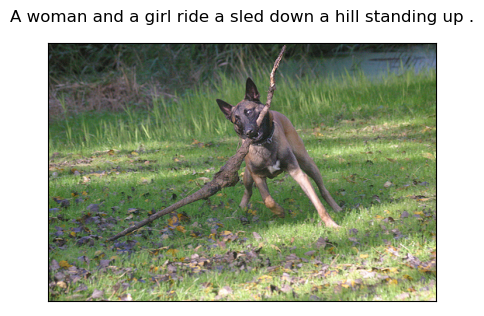

In [ ]:
image_output(index_req, text_req)

In [ ]:
index_req, text_req = test_prediction(test_df_copy.iloc[[78]]) 

  0%|          | 0/1 [00:00<?, ?it/s]

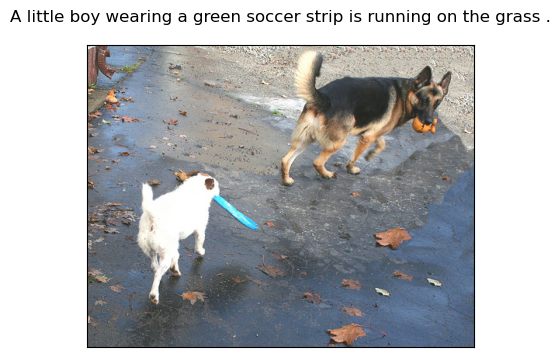

In [ ]:
image_output(index_req, text_req)

## 8. Вывод

Наша модель нейронки хоть и показала более-менее результат при обучении, но на практике она работает не корректно, т к предсказывает рандомную картинку. Для более точных результатов, нужно увеличить кол-во картинок и текста. 